In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans

In [2]:
img_color = cv2.imread('../YourDirectoryID_hw0/Phase1/BSDS500/Images/10.jpg')
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
img_shape = np.shape(img)
print(img_shape)
print(type(img_color))

(481, 321)
<class 'numpy.ndarray'>


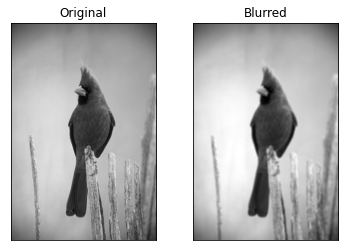

In [3]:
plt.subplot(121),plt.imshow(img,cmap='gist_gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
blur = cv2.GaussianBlur(src=img,ksize=[5,5],sigmaX=5,sigmaY=5)
plt.subplot(122),plt.imshow(blur,cmap='gist_gray'),plt.title('Blurred')
plt.xticks([]), plt.yticks([])

def normalize(image_mat):
    return cv2.normalize(image_mat,dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)


<Figure size 1600x1600 with 0 Axes>

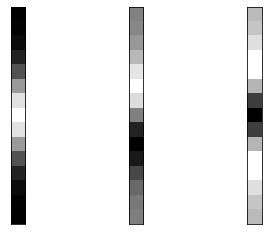

In [4]:
def gaussian1D(dim,sigma,derivative_order,x):
    numerator = pow(x,2)
    variance = pow(sigma,2)
    exponent = numerator/variance
    exponent = -0.5*exponent
    comp = np.exp(exponent)
    comp = comp/(sigma*np.sqrt(2*np.pi))
    scale_factor = 1/np.sum(comp)
    comp = comp*scale_factor
    if derivative_order == 1:
        comp = np.multiply(comp,np.asmatrix(x))
        comp = -comp/pow(sigma,2)
    elif derivative_order == 2:
        comp = np.multiply(comp,(numerator - variance)/(pow(variance,2)))
    return np.transpose(np.asmatrix(comp))

def plot_gaussian1D():
    kernel_size = 15
    val = math.floor(kernel_size/2)
    x = np.arange(-val,val+1,1)
    sigma = 2
    orders = [0,1,2]
    plt.figure(figsize=(8,8),dpi=200)
    fig,axs = plt.subplots(1,len(orders))
    for i,order in enumerate(orders):
        val = gaussian1D(kernel_size,sigma,order,x)
        val = normalize(val)
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))
        
plot_gaussian1D()

<Figure size 1600x1600 with 0 Axes>

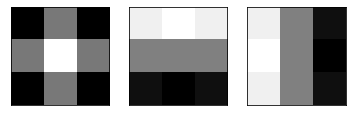

<Figure size 1600x1600 with 0 Axes>

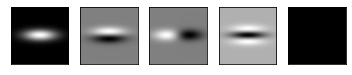

<Figure size 1600x1600 with 0 Axes>

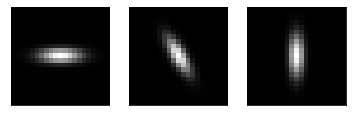

In [5]:
def gaussian2D(dim,sigma_x,sigma_y,x_order,y_order,theta):
    val = math.floor(dim/2)
    x = np.arange(-val,val+1,1)
    y = x
    x2d,y2d = np.meshgrid(x,x)
    coords = np.column_stack((y2d.ravel(),x2d.ravel()))
    rotation_mat = np.matrix([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    points = rotation_mat.dot(coords.transpose())
    ret_x = gaussian1D(dim,sigma_x,x_order,np.asarray(points[0]))
    ret_y = gaussian1D(dim,sigma_y,y_order,np.asarray(points[1]))
    ret = np.multiply(ret_x,ret_y)
    ret = np.reshape(ret,[len(x),len(x)])
    return ret

def plot_symmetricalGaussian2D():
    kernel_size = 3
    sigma = 2
    theta = np.pi*(0/180)
    orders = [[0,0],[1,0],[0,1]]
    plt.figure(figsize=(8,8),dpi=200)
    fig,axs = plt.subplots(1,len(orders))
    for i,order in enumerate(orders):
        val = gaussian2D(kernel_size,sigma,sigma,order[0],order[1],theta)
        val = normalize(val)
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))
        
def plot_asymmetricalGaussian2D():
    kernel_size = 1500
    sigma_x = 100
    sigma_y = 300
    theta = np.pi*(0/180)
    orders = [[0,0],[1,0],[0,1],[2,0],[0,2]]
    plt.figure(figsize=(8,8),dpi=200)
    fig,axs = plt.subplots(1,len(orders))
    for i,order in enumerate(orders):
        val = gaussian2D(kernel_size,sigma_x,sigma_y,order[0],order[1],theta)
        val = normalize(val)
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))

def plot_asymmetricalRotatedGaussian2D():
    kernel_size = 20
    sigma_x = 1
    sigma_y = 3
    thetas = np.array([0,30,60,90,120,150,180,210,240])*np.pi/180
    thetas = np.array([0,60,90])*np.pi/180
    plt.figure(figsize=(8,8),dpi=200)
    fig,axs = plt.subplots(1,len(thetas))
    for i,theta in enumerate(thetas):
        val = gaussian2D(kernel_size,sigma_x,sigma_y,0,0,theta)
        val = normalize(val)
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))
plot_symmetricalGaussian2D()
plot_asymmetricalGaussian2D()
plot_asymmetricalRotatedGaussian2D()


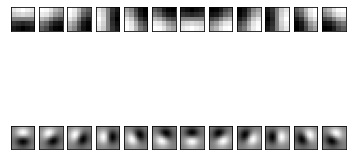

<Figure size 1600x1600 with 0 Axes>

In [6]:
def OrientedDerivativeOfGaussian(kernel_size,sigma,orient):
    sobel_filter_x = gaussian2D(kernel_size,sigma,sigma,1,0,0)
    sobel_filter_y = gaussian2D(kernel_size,sigma,sigma,0,1,0)
    sobel_filter_x = cv2.filter2D(sobel_filter_x,ddepth=-1,kernel=gaussian2D(3,1,1,0,0,0))
    sobel_filter_y = cv2.filter2D(sobel_filter_y,ddepth=-1,kernel=gaussian2D(3,1,1,0,0,0))
    ret = np.cos(orient)*sobel_filter_x + np.sin(orient)*sobel_filter_y
    return ret

def test_DoG_filterbank():
    scales = [5,10]
    sigma = 2
    orients = np.array([0,30,60,90,120,150,180,210,240,270,300,330])*np.pi/180
    fig,axs = plt.subplots(len(scales),len(orients))
    plt.figure(figsize=(8,8),dpi=200)
    for i,scale in enumerate(scales):
        for j,orient in enumerate(orients):
            dog_filter = OrientedDerivativeOfGaussian(scale,sigma,orient)
            val = normalize(dog_filter)
            axs[i,j].set_yticklabels([])
            axs[i,j].set_xticklabels([])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            axs[i,j].imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))
            
test_DoG_filterbank()

In [7]:
kernel_size = 3
sigma = 1
val = math.floor(kernel_size/2)
x = np.arange(-val,val+1,1)
print(x)
custom_1 = gaussian1D(kernel_size,sigma,0,x)
print(custom_1)

cv_gaussian = cv2.getGaussianKernel(3,1)
print(cv_gaussian)


# val = gaussian2D(3,1,1,0,0,0)
# print(val)

# print(cv_gaussian*np.transpose(cv_gaussian))

[-1  0  1]
[[0.27406862]
 [0.45186276]
 [0.27406862]]
[[0.27406862]
 [0.45186276]
 [0.27406862]]


[[ 5.68025672e+01  5.41855326e+01  5.68025672e+01]
 [ 2.71050543e-15 -1.35525272e-15  2.71050543e-15]
 [-5.68025672e+01 -5.41855326e+01 -5.68025672e+01]]


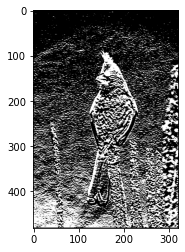

In [8]:
def convolve_odog():
    # dog_filter = gaussian2D(3,2,2,0,0,0)*10
    dog_filter = OrientedDerivativeOfGaussian(3,1,0)*100000
    # dog_filter = normalize(dog_filter)/1000
    plt.imshow(cv2.cvtColor(normalize(dog_filter),cv2.COLOR_BGR2RGB))
    print(dog_filter)
    filtered_img= cv2.filter2D(img,ddepth=-1,kernel=dog_filter)
    plt.imshow(cv2.cvtColor(filtered_img,cv2.COLOR_BGR2RGB))
convolve_odog()

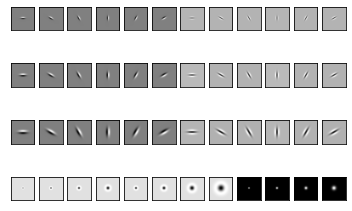

<Figure size 1600x1600 with 0 Axes>

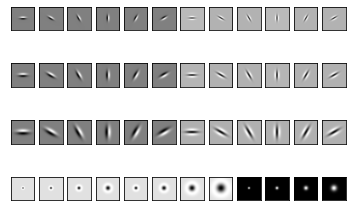

<Figure size 1600x1600 with 0 Axes>

In [9]:
def LM_filterbank(kernel_size,scales):

    orients = np.array([0,30,60,90,120,150])*np.pi/180
    filter_banks = []


    filter_banks = []
    for scale in scales[0:3]:
        scale_filters = []
        #LMS filter_banks first order 6*3 = 18
        for orient in orients:
            scale_filters.append(gaussian2D(kernel_size,scale,3*scale,1,0,orient))
        #LMS filter_banks second order 6*3 = 18
        for orient in orients:
            scale_filters.append(gaussian2D(kernel_size,scale,3*scale,2,0,orient))
        filter_banks.append(scale_filters)

    last_banks = []
    
    #laplacian of gaussians 8
    loG_scales = []
    loG_scales.append(scales)
    loG_scales.append(2*scales)
    loG_scales = [num for elem in loG_scales for num in elem]

    for scale in loG_scales:
        log_x = gaussian2D(kernel_size,scale,scale,2,0,0)
        log_y = gaussian2D(kernel_size,scale,scale,0,2,0)
        last_banks.append(log_x+log_y)
    
    #LMS filter_banks gaussians 4
    for scale in scales:
        last_banks.append(gaussian2D(kernel_size,scale,scale,0,0,0))
    
    filter_banks.append(last_banks)
    return filter_banks

def test_LM_filterbank():
    kernel_size = 49
    scales = np.array([1,np.sqrt(2),2,2*np.sqrt(2)])
    LMS_filter_banks = LM_filterbank(kernel_size,scales)
    fig,axs = plt.subplots(np.shape(LMS_filter_banks)[0],np.shape(LMS_filter_banks)[1])
    plt.figure(figsize=(8,8),dpi=200)
    for i,filters in enumerate(LMS_filter_banks):
        for j,filter_g in enumerate(filters):
            val = normalize(filter_g)
            axs[i,j].set_yticklabels([])
            axs[i,j].set_xticklabels([])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            axs[i,j].imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))
    
    scales = np.array([np.sqrt(2),2,2*np.sqrt(2),4])
    LML_filter_banks = LM_filterbank(kernel_size,scales)
    fig,axs = plt.subplots(np.shape(LML_filter_banks)[0],np.shape(LMS_filter_banks)[1])
    plt.figure(figsize=(8,8),dpi=200)
    for i,filters in enumerate(LML_filter_banks):
        for j,filter_g in enumerate(filters):
            val = normalize(filter_g)
            axs[i,j].set_yticklabels([])
            axs[i,j].set_xticklabels([])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            axs[i,j].imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))

test_LM_filterbank()

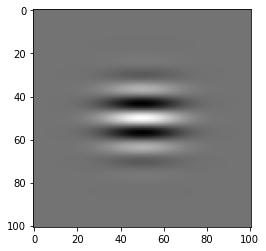

In [10]:
def gabor_filter(dim,lamda,theta,psi,sigma,gamma):
    val = math.floor(dim/2)
    x = np.arange(-val,val+1,1)
    y = x
    x2d,y2d = np.meshgrid(x,x)
    coords = np.column_stack((y2d.ravel(),x2d.ravel()))
    rotation_mat = np.matrix([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
    points = rotation_mat.dot(coords.transpose())
    gaussian_part = np.exp(-(np.power(points[0],2)+np.power(gamma,2)*np.power(points[1],2))/(2*np.power(sigma,2)))
    sinusodial_part_real = np.cos(2*np.pi*points[0]/lamda+psi)
    sinusodial_part_complex = np.sin(2*np.pi*points[0]/lamda+psi)
    comp = []
    comp = np.multiply(gaussian_part,sinusodial_part_real)
    comp = np.reshape(comp,[len(x),len(x)])
    return comp

def test_gabor_filter():
    val = gabor_filter(100,14,np.pi*(0/180),np.pi*(0/180),11,0.9)
    val = normalize(val)
    plt.imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))
test_gabor_filter()

(481, 321)


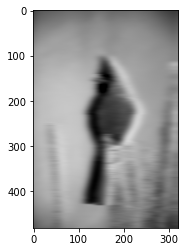

In [11]:
def convolve_img_gabor():
    filters = gabor_filter(100,14,np.pi*(10/180),np.pi*(20/180),11,0.9)/10
    img1= cv2.filter2D(img,ddepth=-1,kernel=filters[47])
    print(np.shape(img))
    plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
convolve_img_gabor()

(1, 61, 61)


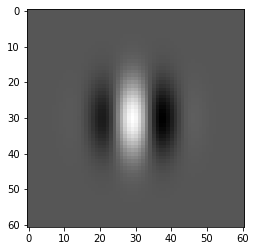

In [12]:
def create_gabor_kernels():
    gabor_kernel_size = 60
    gabor_lambda = [20]
    gabor_theta = np.pi/180*np.array([90])
    gabor_psi = np.pi/180*np.array([20])
    gabor_sigma = [7]
    gabor_gamma = [1]
    gabor_filters = []
    for glambda in gabor_lambda:
        for theta in gabor_theta:
            for psi in gabor_psi:
                for sigma in gabor_sigma:
                    for gamma in gabor_gamma:
                        g_filter = gabor_filter(gabor_kernel_size,glambda,theta,psi,sigma,gamma)
                        gabor_filters.append(g_filter)
    return gabor_filters
gabor_kernels = create_gabor_kernels()
print(np.shape(gabor_kernels))
val = normalize(gabor_kernels[0])
plt.imshow(cv2.cvtColor(val,cv2.COLOR_BGR2RGB))

In [13]:
def group_filters():
    dog_scaling_factor = 100000
    dog_scales = [5,10]
    dog_sigma = 2
    dog_orients = np.array([0,30,60,90,120,150,180,210,240,270,300,330])*np.pi/180
    dog_filters = []
    for scale in dog_scales:
        for orient in dog_orients:
            dog = OrientedDerivativeOfGaussian(scale,dog_sigma,orient)*10000
            dog_filters.append(dog)
    print(np.shape(dog_filters))

    LM_scaling_factor = 2000
    LM_kernel_size = 49
    LMS_scales = np.array([np.sqrt(2),2,2*np.sqrt(2),4])
    LMS_filters = LM_filterbank(LM_kernel_size,LMS_scales)
    LMS_filters = np.reshape(np.array(LMS_filters),[48,49,49])*LM_scaling_factor
    
    LML_scales = np.array([np.sqrt(2),2,2*np.sqrt(2),4])
    LML_filters = LM_filterbank(LM_kernel_size,LML_scales)
    LML_filters = np.reshape(np.array(LML_filters),[48,49,49])*LM_scaling_factor
    
    LM_filters = LMS_filters.tolist() + LML_filters.tolist()
    print(np.shape(LM_filters))

    gabor_kernel_size = 31
    gabor_lambda = [14]
    gabor_theta = np.pi/180*np.array([0,30,50])
    gabor_psi = np.pi/180*np.array([0,10])
    gabor_sigma = [11,15,20]
    gabor_gamma = [0.4,0.5,0.9]
    gabor_filters = []
    for glambda in gabor_lambda:
        for theta in gabor_theta:
            for psi in gabor_psi:
                for sigma in gabor_sigma:
                    for gamma in gabor_gamma:
                        g_filter = gabor_filter(gabor_kernel_size,glambda,theta,psi,sigma,gamma)
                        gabor_filters.append(g_filter)
    print(np.shape(gabor_filters))
    filter_bank = dog_filters
    filter_bank += LM_filters
#     filter_bank += gabor_filters
    return filter_bank
    
filters = group_filters()

(24,)
(96, 49, 49)
(54, 31, 31)


(120, 481, 321)
(481, 321)


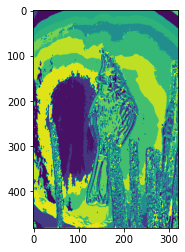

In [40]:
# images = np.empty([img.shape[0],img.shape[1],len(filters)])

# for customFilter in filters:
#     image = cv2.filter2D(img,ddepth=-1,kernel=np.array(filters[0]))
#     image = np.expand_dims(image,axis=2)
#     np.append(images,image,axis=2)

images = []
for customFilter in filters:
    images.append(cv2.filter2D(img,ddepth=-1,kernel=np.array(customFilter)))

print(np.shape(images))


km = KMeans(n_clusters = 64, init='random',n_init=10,max_iter=300,tol=1e-04, random_state=0)
images_reshaped = np.transpose(np.reshape(images,[len(filters),img_shape[0]*img_shape[1]]))
y_km = km.fit_predict(images_reshaped)
clustered_texture = np.reshape(y_km,[img_shape[0],img_shape[1]])
print(np.shape(clustered_texture))
plt.imshow(clustered_texture)

In [46]:
print(np.shape(images))
print(np.shape(np.transpose(images,axes=[1,2,0])))
print(np.shape(images_reshaped))

(120, 481, 321)
(481, 321, 120)
(154401, 120)


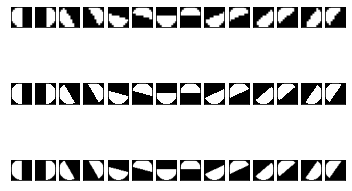

<Figure size 1600x1600 with 0 Axes>

In [17]:
def half_disk_mask_pair(dim,theta):
    val = math.floor(dim/2)
    x = np.arange(-val,val+1,1)
    y = x
    x2d,y2d = np.meshgrid(x,x)
    coords = np.column_stack((y2d.ravel(),x2d.ravel()))
    coords = np.transpose(coords)
    angles = np.arctan2(coords[1],coords[0])
    magnis = np.power(np.power(coords[1],2) + np.power(coords[0],2),0.5)
    image1 = np.full(len(x)*len(x),0)
    image2 = np.full(len(x)*len(x),0)
    
    for i,angle in enumerate(angles):
        if angle >=0 and (angle <= theta or angle == np.pi - theta) and magnis[i] <= len(x)/2:
            image1[i] = 255
        if angle < 0 and angle >= (theta - np.pi) and magnis[i] <= len(x)/2:
            image1[i] = 255
            continue
    for i,angle in enumerate(angles):
        if angle >=0 and (angle > theta and (not angle == np.pi - theta)) and magnis[i] <= len(x)/2:
            image2[i] = 255
        if angle < 0 and (angle < (theta - np.pi)) and magnis[i] <= len(x)/2:
            image2[i] = 255
            continue
    
    image1 = np.reshape(image1,[len(x),len(x)])
    image2 = np.reshape(image2,[len(x),len(x)])
    return [image1,image2]
    
def plot_half_disk_masks():
    scales = [10,20,30]
    orients = np.array([0,30,75,90,115,130,145])*np.pi/180
    fig,axs = plt.subplots(len(scales),2*len(orients))
    plt.figure(figsize=(8,8),dpi=200)
    for i,scale in enumerate(scales):
        if len(scales) > 1:
            ax = axs[i]
        else:
            ax = axs
        for j,orient in enumerate(orients):
            mask = half_disk_mask_pair(scale,orient)
            mask[0] = normalize(mask[0])
            ax[2*j].set_yticklabels([])
            ax[2*j].set_xticklabels([])
            ax[2*j].set_xticks([])
            ax[2*j].set_yticks([])
            ax[2*j].imshow(cv2.cvtColor(mask[0],cv2.COLOR_BGR2RGB))
            mask[1] = normalize(mask[1])
            ax[2*j+1].set_yticklabels([])
            ax[2*j+1].set_xticklabels([])
            ax[2*j+1].set_xticks([])
            ax[2*j+1].set_yticks([])
            ax[2*j+1].imshow(cv2.cvtColor(mask[1],cv2.COLOR_BGR2RGB))
            
plot_half_disk_masks()

In [48]:
# Brightness and color map
def get_cluster_map(img,clusters,n_features):
    img_shape = np.shape(img)
    img_2d = img.reshape(-1,n_features)
    km = KMeans(n_clusters = clusters, init='random',n_init=10,max_iter=300,tol=1e-04, random_state=0)
    clustered_image = km.fit_predict(img_2d)
    clustered_image = np.reshape(clustered_image,(img_shape[0],img_shape[1]))
    return clustered_image
def plot_brightness_color_clustered_map(img,img_color):
    clustered_brightness = get_cluster_map(img,16,1)
    clustered_color = get_cluster_map(img_color,16,3)
    plt.subplot(121),plt.imshow(cv2.cvtColor(normalize(clustered_brightness),cv2.COLOR_BGR2RGB))
    plt.title('clustered_brightness')
    plt.xticks([]),plt.yticks([])
    plt.subplot(122),plt.imshow(cv2.cvtColor(normalize(clustered_color),cv2.COLOR_BGR2RGB))
    plt.title('clustered_color')
    plt.xticks([]),plt.yticks([])

# plot_brightness_color_clustered_map(img,img_color)    

texture_clustered = get_cluster_map(np.transpose(images,axes=[1,2,0]),64,len(filters))
plt.imshow(texture_clustered)


NameError: name 'texture_clustered' is not defined

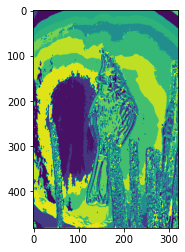

In [49]:
plt.imshow(texturex_clustered)

In [19]:
# gradients
def update_chi_sqr_dist(chi_image,g_i,h_i):
    distance = np.power(g_i - h_i,2)
    np.seterr(invalid='ignore')
    distance = np.divide(distance,(g_i+h_i))
    np.seterr(invalid=None)
    distance = distance/2
    chi_image += distance

def get_gradient(img,left_half,right_half):
    chi_image = np.zeros(np.shape(img))
    img0 = img.flatten()
    tmp = np.zeros(np.shape(img0))
    for i in range(255):
        tmp[img0 == i] = 1
        reshaped_tmp = tmp.reshape(img.shape)
        g_i = cv2.filter2D(reshaped_tmp,ddepth=-1,kernel=left_half)
        h_i = cv2.filter2D(reshaped_tmp,ddepth=-1,kernel=right_half)
        update_chi_sqr_dist(chi_image,g_i,h_i)
    return chi_image

def get_image_gradients(img):
    scales = [10,20,30]
    orients = np.array([0,30,75,90,115,130,145])*np.pi/180
    images = np.empty(len(scales)*len(orients))
    for scale in scales:
        for orient in orients:
            mask = half_disk_mask_pair(scale,orient)
            np.append(images,get_gradient(img,mask[0],mask[1]))
    return images
clustered_brightness = get_cluster_map(img,16,1)
clustered_color = get_cluster_map(img_color,16,3)
clustered_texture = get_cluster_map
brightness_gradients = get_image_gradients(clustered_brightness)
color_gradients = get_image_gradients(clustered_color)



C:\Users\saikr\AppData\Local\Temp\ipykernel_10648\4027666162.py:5: RuntimeWarning: divide by zero encountered in true_divide
  distance = np.divide(distance,(g_i+h_i))


(([], []), ([], []))

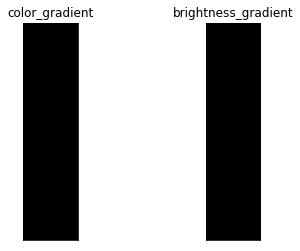

In [20]:
plt.subplot(122),plt.imshow(normalize(brightness_gradients[0]),cmap='gist_gray'),plt.title('brightness_gradient')
plt.xticks([]), plt.yticks([])
plt.subplot(121),plt.imshow(normalize(color_gradients[0]),cmap='gist_gray'),plt.title('color_gradient')
plt.xticks([]), plt.yticks([])

(([], []), ([], []))

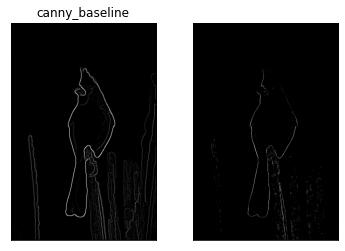

In [21]:
canny_baseline = cv2.imread('../YourDirectoryID_hw0/Phase1/BSDS500/CannyBaseline/10.png',cv2.IMREAD_GRAYSCALE)
sobel_baseline = cv2.imread('../YourDirectoryID_hw0/Phase1/BSDS500/SobelBaseline/10.png',cv2.IMREAD_GRAYSCALE)
plt.subplot(121),plt.imshow(normalize(canny_baseline),cmap='gist_gray'),plt.title('canny_baseline')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(sobel_baseline,cmap='gist_gray'),
plt.xticks([]), plt.yticks([])

In [22]:
#hadamard product
def get_pbEdges(texture_gradients,brightness_gradients,color_gradients,canny_baseline,sobel_baseline,w1,w2):
    sum_of_gradients = np.sum(texture_gradients,axis=0)
    sum_of_gradients += np.sum(brightness_gradients,axis=0)
    sum_of_gradients += np.sum(color_gradients,axis=0)
    gradients_avg = (texture_gradient + brightness_gradient + color_gradient)/2
    baseline_avg = w1*canny_baseline + w2*sobel_baseline
    pbEdges = np.multiply(gradients_avg,baseline_avg)
    return pbEdges
plt.imshow(pbEdges)
plt.imshow(cv2.cvtColor(normalize(pbEdges),cv2.COLOR_BGR2RGB))

NameError: name 'pbEdges' is not defined

In [ ]:
a = np.array(([[0,1,2],[1,2,3],[3,4,5]],[[2,3,5],[5,6,7],[3,4,8]]))
print(a)
print(a.shape)
b = np.sum(a,axis=0)
print(b)